In [663]:
#!pip install opencv-python
#!pip install dlib

In [664]:
import cv2
import dlib
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리

print(cv2.__version__)
print(dlib.__version__)

4.13.0
20.0.0


### 이미지추가
- jeny, 아이브 이미지를 추가해서, 다양성을 높였다..

### 위치계산
- 코 바로 아래 인중으로 하는게 더 자연스러운거 같아서 인중으로 했다..
- y 좌표계산이 처음에 단순하게 list_points[33][1]를 입력했는데, 그러니까 이미지가 턱에 붙었다..
- 이미지 크기가 dlib_rect과 동일하다는것을 간과했음..

###  cat-whiskers.png 파일의 배경색 투병도 처리..
- 처음에 힌샘만 출력...배경이 255(흰색)입니다. 기존 코드는 0만 찾고 있는데 이미지는 255니까, 배경을 투명하게 만들지 못하고 하얀 박스가 그대로 나왔습니다.
- print(img_sticker[0, 0])를 찍어서 배경색이 255,255,255 인것을 확인
- 그래서 0 대신에 255로 바꾸어서  sticker_area로 잘라낸부분으로 채워습니다.

In [665]:
# 1. 이미지 파일 리스트 설정
image_files = ['image.png', 'jeny.jpg', 'ive.jpg']
home_dir = os.getenv('HOME')
project_path = 'Projects/AIFFEL_quest_eng/Computer_Vision/CV01/camera_sticker'
img_sticker_raw = cv2.imread(os.path.join(home_dir, project_path, 'images/cat-whiskers.png'))
# 랜드마크 모델 로드
predictor = dlib.shape_predictor(os.path.join(home_dir, project_path, 'models/shape_predictor_68_face_landmarks.dat'))


In [666]:
def show_result(img_bgr, title="Result"):
    """
    BGR 이미지를 RGB로 변환하여 Matplotlib으로 출력하는 함수
    """
    plt.figure(figsize=(10, 5))
    # 합성된 BGR 이미지를 출력 직전에만 RGB로 변환
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [667]:
def get_sticker_position(list_points, dlib_rect):
    """
    랜드마크에서 인중 위치(33번)를 찾아 스티커의 시작 좌표와 크기를 계산합니다.
    """
    # 33번 인중 기준 좌표
    x = list_points[33][0]
    y = list_points[33][1]
    
    # 스티커 크기는 얼굴 영역 너비로 설정
    w = h = dlib_rect.width()
    
    # 시작점(좌측 상단) 계산: 스티커 중심을 33번에 맞춤
    refined_x = x - w // 2
    refined_y = y - h // 2
    
    return refined_x, refined_y, w, h

In [668]:
def blend_sticker(img_main, img_sticker, x, y):
    """
    배경 이미지와 스티커를 합성합니다. (배경색 255 처리 포함)
    """
    result = img_main.copy()
    
    sh, sw = img_sticker.shape[:2]
    sticker_area = result[y:y+sh, x:x+sw]
    
    # 복사본에만 작업 수행 (In-place 아님)
    result[y:y+sh, x:x+sw] = np.where(img_sticker == 255, sticker_area, img_sticker).astype(np.uint8)
    
    # 새로운 이미지를 반환
    return result



--- image.png 처리 중 ---


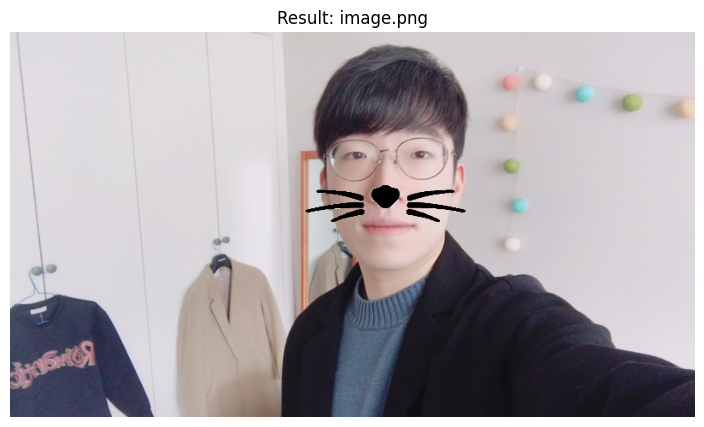


--- jeny.jpg 처리 중 ---


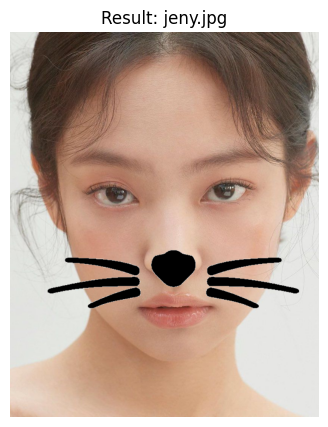


--- ive.jpg 처리 중 ---


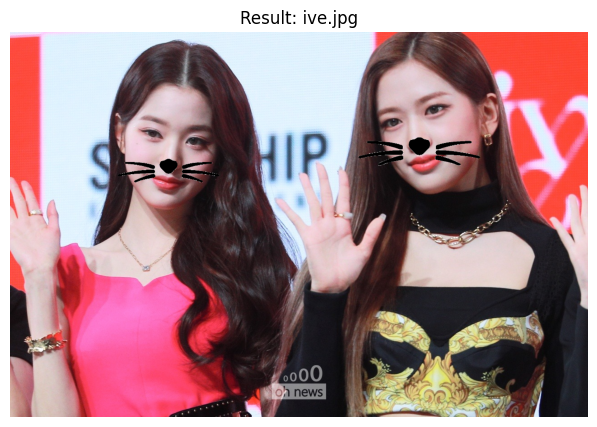

In [669]:
# 2. 루프를 돌며 각 이미지 처리
for file_name in image_files:
    print(f"\n--- {file_name} 처리 중 ---")
    
    # 이미지 읽기 (BGR 상태)
    img_bgr = cv2.imread(os.path.join(home_dir, project_path, 'images', file_name))
    if img_bgr is None: continue
    
    for dlib_rect in dlib.get_frontal_face_detector()(img_bgr, 1):
        # 랜드마크 추출 (img_show 사용)
        points = predictor(img_bgr, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        
        refined_x, refined_y, w, h = get_sticker_position(list_points, dlib_rect)
        
        # 스티커 리사이즈
        img_sticker = cv2.resize(img_sticker_raw, (w, h))
        
        # 이미지 경계 처리
        img_sticker = img_sticker[max(0, -refined_y):, max(0, -refined_x):]
        refined_x, refined_y = max(0, refined_x), max(0, refined_y)
            
        img_bgr = blend_sticker(img_bgr, img_sticker, refined_x, refined_y)

    # 3. 함수 호출을 통한 결과 출력
    show_result(img_bgr, f"Result: {file_name}")

- 이번 프로젝트를 하면서 느낀점, 배운점 \
  OpenCV 라이브러리 사용법을 알게되었다.
- 이번 프로젝트에서 잘 했다고 생각이 드는 점.\
  하나의 이미지만이 아니라, 여러개의 제니 이미지를 테스트해서 일반화 시켰음..
- 이번 프로젝트에서 느낀 문제점.\
  머리가 빨리빨리 돌지 못함.. 만약 cat-whiskers.png가 아니라 다른 배경색을 가진 이미지라면 또 코드스정을 해야할거 같다..투명도와 컬러를 분리해서 처리하는 루틴이 필요 합니다.
- 다음에는 이렇게 해야겠다 생각한 점.\
  블러 등 이미지 꾸미기등을 하면 좋을거 같음..